In [186]:
import random
from typing import Optional
from rl.distribution import Choose, SampledDistribution
from rl.markov_process import Transition
from dataclasses import dataclass
import itertools
from operator import itemgetter

In [108]:
# BAD FIRST ATTEMPT
# class SnakesAndLadders1():
#     def __init__(self, *args, **kwargs):
        
#         # Sets start state
#         self.state = 0
#         # Initially the game is not over
#         self.gameover = False
        
#         # Default behavior with no arguments
#         # I know it's a lot of code lines but I think it reads more clearly
#         if len(args) == 0:
#             self.snakes = {}
#             self.snakes[31] =  6
#             self.snakes[38] =  1
#             self.snakes[49] =  8
#             self.snakes[53] = 17
#             self.snakes[65] = 14
#             self.snakes[70] = 34
#             self.snakes[76] = 37
#             self.snakes[82] = 63
#             self.snakes[88] = 50
#             self.snakes[94] = 42
#             self.snakes[98] = 54
            
#             self.ladders = {}
#             self.ladders[3]  = 39
#             self.ladders[7]  = 48
#             self.ladders[12] = 51
#             self.ladders[20] = 41
#             self.ladders[25] = 57
#             self.ladders[28] = 35
#             self.ladders[45] = 74
#             self.ladders[60] = 85
#             self.ladders[67] = 90
#             self.ladders[69] = 92
#             self.ladders[77] = 83
            
# #             print("sneks", self.snakes)
# #             print("ladders", self.ladders)

#         # For 2 arguments, sets dicts of snakes and ladders
#         elif len(args == 2):
#             self.snakes = args[0]
#             self.ladders = args[1]
#         else:
#             raise ValueError("Can only give me 0 or 2 arguments bro")
    
#     # Checks if the game is over if you've reached 100 or greater
#     # In this version anything 100 and above is counted as an automatic win
#     def isover():
#         if self.state > 99:
#             self.gameover = True
            
#     def roll():
#         # Rolls the dice
#         diceroll = random.randint(1,6)
#         # Adds the result to the current state
#         newstate = self.state + diceroll
        
#         if newstate in self.snakes:
#             # If you land on a snake, you are sent to the state of the snake number's dict result
#             self.state = self.snakes[newstate]
#         elif newstate in self.ladders:
#             # If you land on a ladder, you are sent to the state of the ladder number's dict result
#             self.state = self.ladders[newstate]
#         else:
#             # Sets the new state
#             self.state = newstate
            
#         # Checks if the game is over
#         self.isover()

In [ ]:
# Snakes and Ladders State

# State space is just the value of the square the player is on ranging from [0:100]
@dataclass(frozen=True)
class SLState:
    state: int

# Finite Markov Process of the Snakes and Ladders game
class SnakesAndLaddersFMP(FiniteMarkovProcess[SLState]):
    def __init__(
        self,
        start: SLState =SLState(0),
        maxx: SLState =SLState(100),
        slides: dict =None
    ):
        
        self.start = start.state
        self.max = maxx.state
        
        if slides == None:
            # Creates the snakes and ladders dict map
            # I know it's a lot of code lines but I think it reads more clearly
            self.slides = {}
            # Snakes
            self.slides[31] =  6
            self.slides[38] =  1
            self.slides[49] =  8
            self.slides[53] = 17
            self.slides[65] = 14
            self.slides[70] = 34
            self.slides[76] = 37
            self.slides[82] = 63
            self.slides[88] = 50
            self.slides[94] = 42
            self.slides[98] = 54
            # Ladders
            self.slides[3]  = 39
            self.slides[7]  = 48
            self.slides[12] = 51
            self.slides[20] = 41
            self.slides[25] = 57
            self.slides[28] = 35
            self.slides[45] = 74
            self.slides[60] = 85
            self.slides[67] = 90
            self.slides[69] = 92
            self.slides[77] = 83
        else:
            self.slides = slides
            
        self.t_map = self.get_transition_map()

    # Given the current state, returns a list of possible next states with a roll from [1:6]
    # Accounts for snakes and ladders
    # If the state is the max or greater, the value is set to the max
    def setlist(self, curstate):
        listt = []
        for i in range(1,7):
            newstate = curstate + i
            if newstate in self.slides:
                listt.append(self.slides[newstate])
            elif newstate > self.max:
                listt.append(self.max)
            else:
                listt.append(newstate)
        return listt
    
    # Creates a map from each square to each possible square from that location in a Choose type
    # After the max value is chosen, you can only transition to the square -1 and stay there
    def get_transition_map(self)  -> Transition[SLState]:
        d: Dict[SLState, Choose[list[int]]] = {}
        for state in range(self.start, self.max):   
            d[SLState(state)] = Choose(self.setlist(state))
        d[SLState(-1)] = Choose([-1])
        d[SLState(self.max)] = Choose([-1])
        return d
    
    # Gets next state from current state by sampling from current state's mapped possibilities
    def next_state(self, state: SLState) -> Optional[SLState]:
        
        nextstate = self.t_map[state].sample()
#         print("state: ", state)
#         print("roll: ", nextstate)
        return SLState(nextstate)

 

In [202]:
# Plots for simulating the game and processing the simulation into an array       
def simulation(process, start_state):
    state = start_state
    while True:
        yield state
        state = process.next_state(state)
        
def process_trace(
    start: int,
    maxx: int,
    slides: Optional[dict],
    time_steps: int,
    num_traces: int
) -> np.ndarray:
    
    process = SnakesAndLaddersFMP()
    start_state = SLState(start)
    return np.vstack([
        np.fromiter((s.state for s in itertools.islice(
            simulation(process, start_state),
            time_steps + 1
        )), float) for _ in range(num_traces)])

The expected number of steps to finish shoots and ladders is  39.78105621124225  rolls


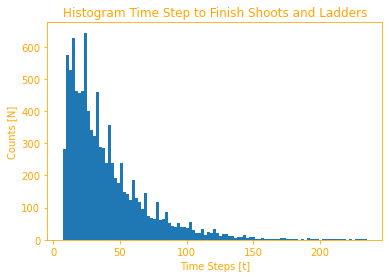

In [226]:
# Simulates Shoots and Ladders and then plots a histogram of the times steps it took to finish
start = 0
terminal = 100
steps = 250
traces = 10000
trace = process_trace(start, terminal, None, steps, traces )


from matplotlib import pyplot as plt
%matplotlib inline

# Gets the location of the terminal states
where = np.argwhere(trace == terminal)
x = where[:,1]

# Gets the average for the expectation
avg = np.nanmean(x)
print("The expected number of steps to finish shoots and ladders is ", avg, " rolls")

# Plot stuff...
fig, ax = plt.subplots()

# I changed the label and tick colors since I have a dark theme
custom_color = 'orange'

# Axes stuffs
n_bins = terminal - start + 1
ax.hist(x, n_bins)
ax.set_xlabel('Time Steps [t]').set_color(custom_color)
ax.set_ylabel('Counts [N]').set_color(custom_color)
ax.set_title(r'Histogram Time Step to Finish Shoots and Ladders').set_color(custom_color)

# Additional color info
ax.spines['bottom'].set_color(custom_color)
ax.spines['top'].set_color(custom_color)
ax.spines['left'].set_color(custom_color)
ax.spines['right'].set_color(custom_color)
ax.tick_params(axis='x', colors=custom_color)
ax.tick_params(axis='y', colors=custom_color)

# Show off baby
plt.show()

In [171]:
trace

array([[ 0.,  4., 48., ..., 87., 50., 52.],
       [ 0., 39., 40., ..., 78., 79., 85.],
       [ 0.,  5., 48., ..., 23., 57., 62.],
       ...,
       [ 0., 39., 41., ..., 17., 21., 23.],
       [ 0.,  6., 51., ..., 58., 61., 14.],
       [ 0.,  6., 48., ..., 26., 32.,  1.]])

In [183]:
b = Choose([-1])
print(b.sample())
type(b.sample())

-1


int

In [152]:
arr

array([[  0.,   1.,  39., ..., 100., 100., 100.],
       [  0.,   2.,   6., ..., 100., 100., 100.],
       [  0.,   5.,  11., ..., 100., 100., 100.],
       ...,
       [  0.,   4.,  10., ..., 100., 100., 100.],
       [  0.,   6.,  11., ..., 100., 100., 100.],
       [  0.,   2.,   6., ..., 100., 100., 100.]])

In [59]:
import numpy as np
np.maximum(0, np.max([1,3,4]))
a = [1,2,3]
b = np.array(a)
print(b.size)

3
